In [1]:
import sys
sys.path.append('../..') 
import numpy as np
import cv2 as cv
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow import keras
import gc
import matplotlib.pyplot as plt
from tools.GA.FilterGeneticAlgorithm import FilterGeneticAlgorithm
import random as rnd
from tools.GA.CropGeneticAlgorithm import CropGeneticAlgorithm

In [2]:
path = "../datasets/Images/Skin canser"

items = os.listdir(path)

folder_paths = [path+"/"+item for item in items if os.path.isdir(os.path.join(path, item))]

for path in folder_paths:
    print(path)

../datasets/Images/Skin canser/benign
../datasets/Images/Skin canser/malignant


In [3]:
def get_Data(folder_path,cls):
    X = []
    Y=[]
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            img=cv.imread(os.path.join(root, filename))
            img=cv.cvtColor(img, cv.COLOR_RGB2BGR)
            img=cv.resize(img, (224,224))
            X.append(img)
            Y.append(cls)
    return X,Y

In [4]:
X=[]
Y=[]

for cls,folder_path in enumerate(folder_paths):
    x,y=get_Data(folder_path,cls)
    X=X+x
    Y=Y+y

In [5]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3)

In [6]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

print(f"X_train:{X_train.shape} Y_train:{Y_train.shape} X_test:{X_test.shape} Y_test:{Y_test.shape}")

X_train:(2307, 224, 224, 3) Y_train:(2307,) X_test:(990, 224, 224, 3) Y_test:(990,)


In [7]:
model = keras.models.Sequential([
    layers.BatchNormalization(input_shape=(224, 224, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dense(2, activation='softmax')
])

In [8]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
splits = list(kf.split(X_test))

In [9]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(X_test)[train_index], np.array(X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

4/4 [==============================] - 0s 13ms/step - loss: 1.3039 - accuracy: 0.6667
0.5919191926717758


In [10]:
def flatten_extend(matrix):
    return [item for row in matrix for item in row]

def images_to_vectors(images):
    vectors=[]
    for img in images:
        vectors.append(np.array(img).flatten())     
    return vectors

X_train_vectors= images_to_vectors(X_train)
X_test_vectors= images_to_vectors(X_test)
print(f"train: {np.array(X_train_vectors).shape}")
print(f"test: {np.array(X_test_vectors).shape}")

train: (2307, 150528)
test: (990, 150528)


In [11]:
filterGeneticAlgorithm=FilterGeneticAlgorithm(X_train=X_train,X_test=X_test,Y_train=Y_train,Y_test=Y_test, model=model, loss=keras.losses.SparseCategoricalCrossentropy())

In [12]:
best_solution= filterGeneticAlgorithm.run(generation_limit=5, population_size=20)

--------------------------------------------------------------------------------
8/8 [==============================] - 0s 15ms/step - loss: 1.3435 - accuracy: 0.5783
filter [0, 179, 0, 255, 0, 255, 0, 0, 0, 0, 5, 1, 1, 100, 200, 0] fit: 0.6531714797019958
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 15ms/step - loss: 0.6137 - accuracy: 0.7174
filter [37, 166, 19, 238, 20, 108, 79, 6, 65, 160, 20, 5, 1, 133, 367, 2] fit: 0.6809580326080322
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 16ms/step - loss: 0.6140 - accuracy: 0.6217
filter [27, 114, 25, 186, 75, 240, 96, 66, 143, 106, 17, 5, 1, 62, 39, 2] fit: 0.6506248831748962
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 16ms/step - loss: 0.9136 - accuracy: 0.5609
filter [46, 88, 1, 218, 37, 246, 99, 140, 188,

In [13]:
print(f"\nbest filter :{best_solution.filter} fit: {best_solution.fit}")


best filter :[28, 133, 145, 227, 65, 236, 61, 28, 141, 184, 26, 1, 5, 55, 243, 0] fit: 0.7655053615570069


In [14]:
filtered_X_train=np.array(filterGeneticAlgorithm.get_newData(X_train,filter=[37, 115, 48, 222, 52, 232, 50, 51, 159, 94, 5, 3, 2, 2, 62, 0]))
filtered_X_test=np.array(filterGeneticAlgorithm.get_newData(X_test,filter=[37, 115, 48, 222, 52, 232, 50, 51, 159, 94, 5, 3, 2, 2, 62, 0]))


print(f"X_train:{filtered_X_train.shape} Y_train:{Y_train.shape} X_test:{filtered_X_test.shape} Y_test:{Y_test.shape}")

X_train:(2307, 224, 224, 3) Y_train:(2307,) X_test:(990, 224, 224, 3) Y_test:(990,)


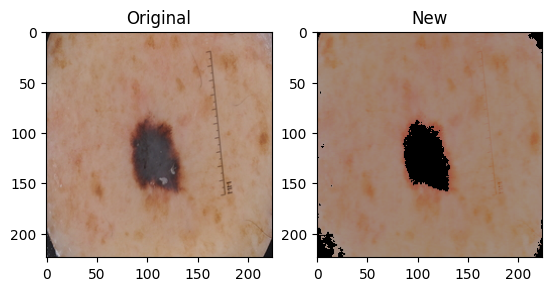

In [15]:
index=rnd.randint(0,len(X_test))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(X_test[index])
ax1.set_title('Original')

ax2.imshow(filtered_X_test[index])
ax2.set_title('New')

plt.show()

In [16]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(filtered_X_test)[train_index], np.array(filtered_X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

4/4 [==============================] - 0s 13ms/step - loss: 0.8662 - accuracy: 0.8182
0.7545454442501068


In [17]:
cropGeneticAlgorithm=CropGeneticAlgorithm(X_train=filtered_X_train,X_test=filtered_X_test,Y_train=Y_train,Y_test=Y_test, model=model, loss=keras.losses.SparseCategoricalCrossentropy())

In [19]:
best_solution=cropGeneticAlgorithm.run(generation_limit= 10, population_size= 10)

--------------------------------------------------------------------------------
8/8 [==============================] - 0s 17ms/step - loss: 0.5019 - accuracy: 0.7739
crop [(0, 224), (0, 224)] fit: 0.767654812335968
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 18ms/step - loss: 0.6863 - accuracy: 0.5783
crop [(212, 213), (206, 219)] fit: 0.6302446842193603
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 17ms/step - loss: 0.5692 - accuracy: 0.7478
crop [(23, 102), (25, 150)] fit: 0.7516149044036865
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 18ms/step - loss: 0.6523 - accuracy: 0.7348
crop [(90, 140), (68, 129)] fit: 0.7255994796752929
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 17

In [21]:
best_solution.crop_dimension

[(0, 224), (0, 224)]

In [23]:
cropped_X_train=np.array(cropGeneticAlgorithm.get_newData(filtered_X_train,best_solution.crop_dimension))
cropped_X_test=np.array(cropGeneticAlgorithm.get_newData(filtered_X_test,best_solution.crop_dimension))

print(f"X_train:{cropped_X_train.shape} Y_train:{Y_train.shape} X_test:{cropped_X_test.shape} Y_test:{Y_test.shape}")

X_train:(2307, 224, 224, 3) Y_train:(2307,) X_test:(990, 224, 224, 3) Y_test:(990,)


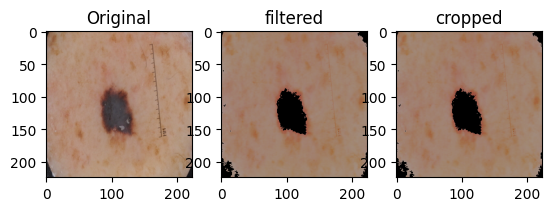

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(X_test[index])
ax1.set_title('Original')

ax2.imshow(filtered_X_test[index])
ax2.set_title('filtered')

ax3.imshow(cropped_X_test[index])
ax3.set_title('cropped')

plt.show()

In [27]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(filtered_X_test)[train_index], np.array(filtered_X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

4/4 [==============================] - 0s 13ms/step - loss: 0.6370 - accuracy: 0.8384
0.7616161584854126
